Cooper Email:

Hi Cooper,

Hope you're finals weeks is slightly less hectic than mine. I was wondering if we could find a time to chat for 15 minutes about 
our implementation of LUNA. We're free Saturday, Sunday or Monday anytime.
 1.  For two pairs of auxillary functions, how do we calculate the dissimalarity score across observations X? Do we average the dissimilarity
 scores from each observation? Are we thinking about this incorrectly?
 2. We're struggling to implement finite differences with multidimensional input data because of some weird autograd bug, and we're wondering 
 if you've ever encountered this.
 3. We're wondering if you have any tips on how to tune LUNA

 Thanks!
 Michael


In [1]:
# import standard libraries
!pip install autograd
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys

# import our libraries
import bayes_helpers as bh
from utils import generate_data
from utils import run_toy_nn
from feed_forward import Feedforward
from nlm import NLM
from luna import LUNA

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# from nlm import NLM

# class LUNA(NLM):
#     """
#     Fits LUNA Model; inherits from NLM and overrides the objective function
    
#     Model Assumptions
#      - Weights distributed normally
#      - Ys distributed normally

#      How to use:
#       - run train() to create: 
#             a) the NN MLE weights, found in self.ff.weights 
#             b) self.posterior samples, the distribution for the weights in the last layer of NLM
     
#       - run predict() to get distribution of ys, given x test
#     """

#     def __init__(self, prior_var, y_noise_var, architecture, random, grad_func = None):
#         '''
#         Important attributes:
        
#         All the NLM attributes

#         NN attributes:
#             self.D = not exactly sure...
#             self.D_in = dimensionality of input data
#             self.D_out = dimensionality of output data
#             self.H = width of a layer in the NN
#         '''

#         #inherit from NLM, override objective func
#         super().__init__(prior_var, y_noise_var, architecture, random, self.make_objective) 
#         self.D, self.D_in, self.D_out, self.H = self.ff.D, architecture['input_dim'], architecture['output_dim'], architecture['width']

#         # override default finite difference method for cosine similarity calc (see cos_sim_sq function)
#         if grad_func:
#             self.grad_func = grad_func
#         else:
#             self.grad_func = self.default_finite_diff
                
#     def similarity_score(self, W, x):
#         '''
#         Calculates total sum of squared cosine similarity between all pairwise combinations of aux 
#         functions
        
#         Inputs: 
#         - W = NumPy array of weights [dim=(1, width H, input dimension D_in)]

#         Returns:
#         - score = total cosine similarity squared across all pairs of functions [scalar]

#         ''' 

#         #D_out = self.D_out
#         score = 0

#         #derivs of all the aux funcs
#         holy_grail = self.grad_func(W, x)

#         # in dim x out dim x # obs
#         M = holy_grail.shape[1]
#         for i in range(self.D_out):
#             grad_i = holy_grail[:,i,:]
#             for j in range(i + 1, self.D_out):
#                 grad_j = holy_grail[:,j,:]
#                 score += self.cos_sim_sq(grad_i, grad_j)
#         return score

#     def cos_sim_sq(self,grad_i, grad_j):
#         numer = np.dot(grad_i, grad_j.T)**2
#         denom = (np.dot(grad_i,grad_i.T)*np.dot(grad_j,grad_j.T))
#         return (numer/denom)[0][0]

    
#     def default_finite_diff(self,W,x):
#         '''
#         x.shape[0] is # of dimensions == self.D_in
#         x.shape[1] is # of observations

#         output: Returns a 3d matrix:
#                 (in dimension) x (out dimension (# of aux functions)) x (# observations)

#                 i.e. for each auxillary function and for each observation, approximate the gradient with dimension x.shape[0]
#         '''
        
#         #create one epsilon for each observation
#         eps = np.random.normal(0,0.1,size=x.shape[1])

#         #iterate over features of raw input data (rows of x)
#         out = np.zeros((self.D_in, self.D_out, x.shape[1]))

#         #evaluate function at x
#         f_ex = self.ff.forward(W, x)

#         assert x.shape[0] == self.D_in

#         #for one dimension at a time
#         for i in range(x.shape[0]):

#             delta = np.zeros(x.shape)
#             delta[i,:] = eps

#             f_eps = self.ff.forward(W,x+delta)

#             # out dim X #obs
#             res = (f_eps - f_ex)/eps
#             #print(res, res.shape)
#             #print(out[i,:,:].shape)
#             #print(res[0].shape)
#             #print(res[0][0][0]._value)
#             # for j in range(self.D_out):
#             #     for k in range(x.shape[1]):
#             #         print(res[0][j][k]._value)
#             #         p = res[0][j][k]._value
#             #         out[i,j,k] = p
#             #out[i,:,:] = res[0] # value wise division, different epsilon for each column
#             # NEED TO FIX FOR MULTIDIMENSIONAL INPUT DATA

#         return res
        
#     def mean_mean_sq_error(self, W):
#         '''
#         Calculates average mean sq error across each output nodes (=the aux functions)
        
#         Inputs: 
#         - W = NumPy array of all weights [dim=(1, width H, input dimension D_in)]

#         Returns:
#         - mean_mse = mean of mean sq error for each aux function [scalar]
#         ''' 
#         D, D_out, H = self.D, self.D_out, self.H
#         aux_outputs = self.ff.forward(W, x_train) #shape = (1,10,12)
#         Y = np.tile(y_train, D_out).reshape(1, D_out, y_train.shape[1])

#         # calculate squared error for each aux regressor, take mean
#         mean_mse = np.mean(np.linalg.norm(Y - aux_outputs, axis=1)**2)

#         return mean_mse

#     def make_objective(self, x_train, y_train, reg_param):
#         '''
#         Makes objective function and gradient of obj function 
        
#         Inputs: 
#         - x_train = NumPy array of training data [dim=(1, anything)]
#         - y_train = NumPy array of training data [dim=(1, anything)]
#         - reg_param = regularization parameter [scalar]

#         Returns:
#         - objective = function handle for objective function
#         - grad(objective) = Autograd gradient of objective function
#         ''' 

#         def objective(W, t):
#             '''
#             Calculates objective function: L_luna(model) = L_fit(model) - L_similarity(model)
#             L_fit(model) = average mean sq error across all outputs/aux functions
#             L_similarity(model) = sum of squared cosine similarity across all aux function combinations
            
#             Inputs: 
#             - W = NumPy array of all weights [dim=(1, width H, input dimension D_in)]
#             - t = necessary for adam solver in Autograd (something about creating a callback)

#             Returns:
#             - L_fit - L_sim = function handle for objective function [scalar]
#             '''
#             # L_luna(model) = L_fit(model) - L_similarity(model)
#             reg_param = 0.1 #eventually this will become an input
#             lambda_ = 0.1 #eventually this will become an input
#             L_sim = lambda_*self.similarity_score(W, x_train)

#             regularization_penalty = reg_param*np.linalg.norm(W)**2
#             mean_mse = self.mean_mean_sq_error(W)
#             L_fit = mean_mse - regularization_penalty

#             return L_fit - L_sim

#         return objective, grad(objective)

### Define Hyperameters

In [3]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 10
hidden_layers = 2
input_dim = 1
num_auxiliary_functions = 7

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': num_auxiliary_functions,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}
prior_var, y_noise_var = 1.0, 1.0
random = np.random.RandomState(0)
# add regularization and similarity parameters
luna = LUNA(prior_var, y_noise_var, 1.0, 0.1, architecture, random)

params = {'step_size':3e-3, 
          'max_iteration':1500, 
          'random_restarts':1,
          'optimizer':'adam'}
x_train, y_train, x_test = generate_data(number_of_points=30, gap_size=1, boundary_size=1)
x_train = x_train.reshape((1,-1))
y_train = y_train.reshape((1,-1))
x_test = x_test.reshape((1,-1))

luna.train(x_train, y_train, params)

doing a random restart
ding
 Iteration 1498 lower bound -5374.659176111588; gradient mag: 182.092653736283dong

Done Training


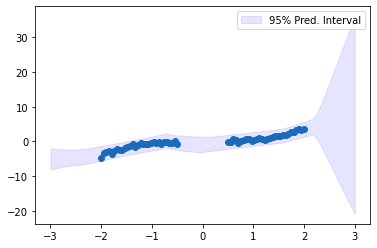

In [ ]:
fig, ax = plt.subplots()

posterior_predictions, posterior_predictive_samples = luna.predict(x_test)

# Compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0).reshape((1,-1)) 

ax.scatter(x_train, y_train)
ax.fill_between(x_test.reshape(-1), pp_upper, pp_lower, color='blue', alpha=0.1, label='95% Pred. Interval') 
ax.legend()

plt.show()

 Iteration 1000 lower bound -327.6087437494777; gradient mag: 35.89945708709121
Done Training
 Iteration 1000 lower bound -1123.7018260502246; gradient mag: 46.863750558231594
Done Training
 Iteration 1000 lower bound -2406.6440674248815; gradient mag: 54.49124132973018
Done Training


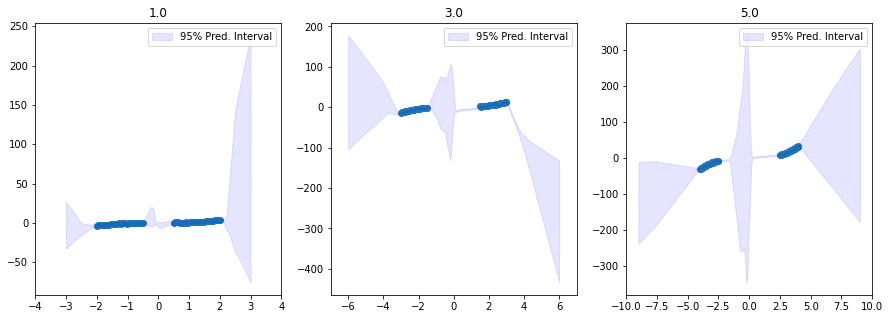

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, gap_size in enumerate([1.0, 3.0, 5.0]):
    boundary_size = gap_size
    

    luna.train(x_train, y_train, params)

    posterior_predictions, posterior_predictive_samples = luna.predict(x_test)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    pp_mean = np.mean(posterior_predictive_samples, axis=0).reshape((1,-1)) 

    ax = axes[i]
    ax.set_xlim([x_train.min() - boundary_size - 1, x_train.max() + boundary_size + 1])
    # ax.set_ylim([-y_train.min() - 1,y_train.max() + 1])
    ax.scatter(x_train, y_train)
    # visualize the 95% posterior predictive interval
    ax.fill_between(x_test.reshape(-1), pp_upper, pp_lower, color='blue', alpha=0.1, label='95% Pred. Interval') 
    ax.legend()
    ax.set_title(str(gap_size))

plt.show()

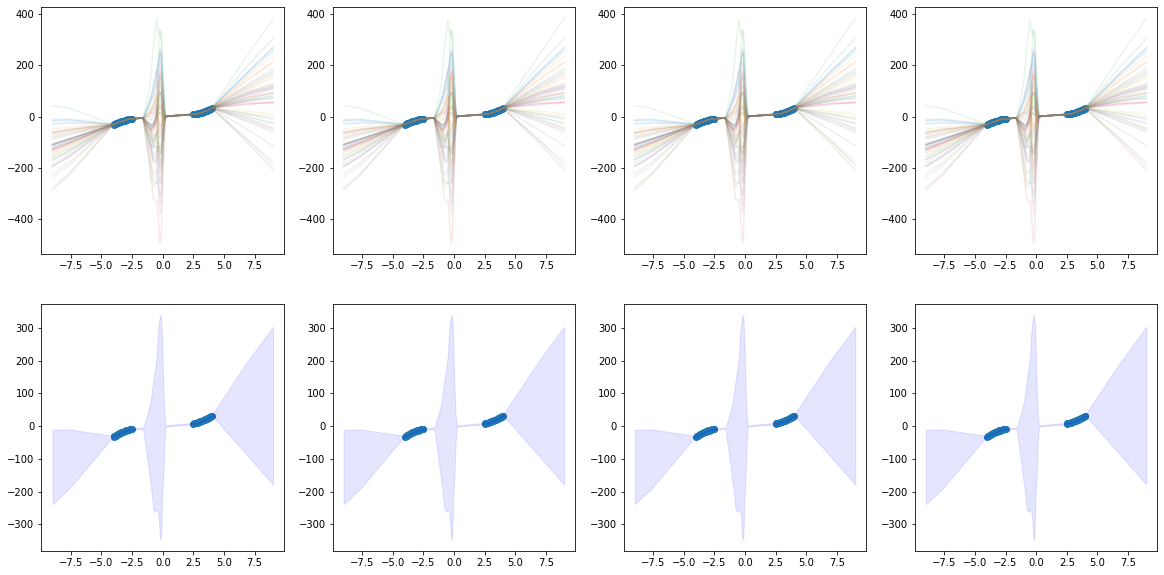

In [ ]:
sizes = [2,4,8,12]
n = len(sizes)
fig, ax = plt.subplots(2, n, figsize = (5*n, 10))

for i, size in enumerate(sizes):
    
    for j in range(50):
        ax[0,i].plot(x_test.flatten(), posterior_predictions[j,:], alpha = 0.1)

    # ax[0,i].set_xlim([-size, size])
    # ax[0,i].set_ylim([-2*size,2*size])
    ax[0,i].scatter(x_train, y_train)

    # ax[1,i].set_xlim([-size, size])
    # ax[1,i].set_ylim([-2*size,2*size])
    ax[1,i].scatter(x_train, y_train)
    # visualize the 95% posterior predictive interval
    ax[1,i].fill_between(x_test.reshape(-1), pp_upper, pp_lower, color='blue', alpha=0.1, label='95% Pred. Interval') 
    
        
plt.show()